#  Multi-Output MLP for Side-Channel Analysis 
- ASCAD Dataset
    - No 1st order data leakage
    - Aligned (suitable for MLP) 
- Nonprofiled attack

- 256 different key guesses "k" 
    - each with it's own, individually tracked hidden network and loss
- LSB leakage model: $ L_k = \text{Sbox}[P \oplus k] \mod 2 $


# 1. Imports

In [ ]:
import os
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import from src package
from src.config import (
    MLP_LEARNING_RATE, MLP_SHARED_DIM, MLP_BRANCH_LAYER_1, MLP_BRANCH_LAYER_2, MLP_OUTPUT_CLASSES,
    NUM_TRACES, TRACE_START_IDX, TARGET_BYTE_IDX, MLP_BATCH_SIZE, MLP_NUM_EPOCHS,
    FILE_PATH, AES_Sbox, CHECKPOINT_DIR
)
from src.model import MultiOutputNet
from src.experiment import ExperimentManager
from src.utils import load_ascad, normalize_traces, generate_labels

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Hyperparameters
Ranked by estimated impact on model performance

In [2]:
# Hyperparameters are imported from src/config.py
# You can override them here if needed for experimentation:

# LEARNING_RATE = 0.0005       # [1e-5, 1e-2]
# SHARED_DIM = 0               # 0 = no shared layer, try [50, 100, 200]
# BRANCH_LAYER_1 = 20          # Suggested range: [10, 50]
# BRANCH_LAYER_2 = 10          # Suggested range: [5, 25]
# OUTPUT_CLASSES = 2           # Binary classification (LSB leakage model)
# NUM_TRACES = 10000           # For ASCAD: 10k -> 50k
# TRACE_START_IDX = 0          # Starting index in dataset
# BATCH_SIZE = 100             # [32, 256]
# NUM_EPOCHS = 30              # Researchers see success in ~6 epochs
# TARGET_BYTE_IDX = 2          # ASCAD shows 2nd-order leakage at byte index 2

print("Current configuration (from src/config.py):")
print(f"  MLP_LEARNING_RATE:  {MLP_LEARNING_RATE}")
print(f"  MLP_SHARED_DIM:     {MLP_SHARED_DIM}")
print(f"  MLP_BRANCH_LAYER_1: {MLP_BRANCH_LAYER_1}")
print(f"  MLP_BRANCH_LAYER_2: {MLP_BRANCH_LAYER_2}")
print(f"  MLP_NUM_EPOCHS:     {MLP_NUM_EPOCHS}")
print(f"  NUM_TRACES:         {NUM_TRACES}")
print(f"  MLP_BATCH_SIZE:     {MLP_BATCH_SIZE}")

Current configuration (from src/config.py):
  MLP_LEARNING_RATE:  0.0001
  MLP_SHARED_DIM:     0
  MLP_BRANCH_LAYER_1: 20
  MLP_BRANCH_LAYER_2: 10
  MLP_NUM_EPOCHS:     50
  NUM_TRACES:         10000
  MLP_BATCH_SIZE:     1000


## 2. Dataset Loading 

In [3]:
# Load data using imported functions (FILE_PATH, AES_Sbox from src/config.py)
traces, plaintexts, real_key = load_ascad(
    FILE_PATH, 
    num_traces=NUM_TRACES, 
    start_idx=TRACE_START_IDX, 
    target_byte=TARGET_BYTE_IDX
)

# Normalize traces and convert to tensor
traces_tensor = normalize_traces(traces)
print("Traces shape:", traces_tensor.shape)
print("Real Key Byte:", hex(real_key))

Traces shape: torch.Size([10000, 700])
Real Key Byte: 0xe0


## 3. Label Generation

We generate 256 sets of labels, one for each key candidate.

In [4]:
# Generate labels using imported function (uses LSB leakage model)
labels_tensor = generate_labels(plaintexts)
print("Labels shape:", labels_tensor.shape)

Labels shape: torch.Size([10000, 256])


## 4. Multi-Output Model Architecture

- Shared Layer (optional): Research shows 200 is most efficient for compute
- 256 Branches: Dense(20) -> ReLU -> Dense(10) -> ReLU -> Dense(2)

In [5]:
# Create model using imported class from src/model.py
input_dim = traces_tensor.shape[1]  # Dynamically get input dimension

model = MultiOutputNet(
    input_dim=input_dim,
    shared_dim=MLP_SHARED_DIM,
    branch_l1=MLP_BRANCH_LAYER_1,
    branch_l2=MLP_BRANCH_LAYER_2,
    output_classes=MLP_OUTPUT_CLASSES
).to(device)

print(f"Model created with input_dim={input_dim}, shared_dim={MLP_SHARED_DIM}, branches={MLP_BRANCH_LAYER_1}→{MLP_BRANCH_LAYER_2}→{MLP_OUTPUT_CLASSES}")

Model created with input_dim=700, shared_dim=0, branches=20→10→2


## 5. Training Loop

- Loss Per-branch: $\mathcal{L}^{[k]} = -\frac{1}{N_s}\sum y_{true} \ln(z)$ (cross-entropy)
- Total Loss: - Total: $\mathcal{L}_{total} = \frac{1}{256}\sum_{k=1}^{256} \mathcal{L}^{[k]}$ (mean for gradient stability)
- Optimizer: Adam

In [6]:
dataset = TensorDataset(traces_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=MLP_BATCH_SIZE, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=MLP_LEARNING_RATE)

history_loss = []

# To track scores of each key guess (higher score = more likely correct key)
# Score = negative loss, so correct key (lowest loss) has highest score
key_scores = np.zeros((MLP_NUM_EPOCHS, 256))

for epoch in range(MLP_NUM_EPOCHS):
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{MLP_NUM_EPOCHS}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data) # (Batch, 256, 2)
        
        # Compute loss: Average of CrossEntropy per branch
        # For each branch k, compute CrossEntropyLoss, then average over all 256 branches
        loss = 0
        for k in range(256):
            loss += criterion(output[:, k, :], target[:, k])
        loss = loss / 256
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(loader)}")
    
    # Validation: Check loss per branch on the whole set (or subset)
    model.eval()
    with torch.no_grad():
        # Compute full validation loss per branch
        # To avoid OOM, do in batches
        val_accum_loss = torch.zeros(256, device=device)
        val_count = 0
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data) # (B, 256, 2)
            
            # Compute loss per branch alone
            for k in range(256):
                val_accum_loss[k] += nn.CrossEntropyLoss(reduction='sum')(out[:, k, :], target[:, k])
            
            val_count += data.size(0)
            
        avg_branch_losses = val_accum_loss / val_count
        # Convert loss to score: negate so that lower loss = higher score
        key_scores[epoch] = -avg_branch_losses.cpu().numpy()
        
        # Rank keys by score (descending - highest score is best)
        sorted_keys = np.argsort(key_scores[epoch])[::-1]  # Reverse for descending order
        best_score_key = sorted_keys[0]
        rank_of_real = np.where(sorted_keys == real_key)[0][0]
        
        print(f"Best Key: {hex(best_score_key)}, Real Key Rank: {rank_of_real}, Real Key Score: {key_scores[epoch][real_key]:.4f}")

Epoch 1/50: 100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


Epoch 1 Avg Loss: 0.7021715581417084
Best Key: 0xe, Real Key Rank: 146, Real Key Score: -0.6967


Epoch 2/50: 100%|██████████| 10/10 [00:01<00:00,  5.18it/s]


Epoch 2 Avg Loss: 0.6985985159873962
Best Key: 0xe, Real Key Rank: 147, Real Key Score: -0.6951


Epoch 3/50: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch 3 Avg Loss: 0.6969821214675903
Best Key: 0xe, Real Key Rank: 149, Real Key Score: -0.6945


Epoch 4/50: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


Epoch 4 Avg Loss: 0.6959687113761902
Best Key: 0xe, Real Key Rank: 145, Real Key Score: -0.6937


Epoch 5/50: 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


Epoch 5 Avg Loss: 0.6952471673488617
Best Key: 0xd4, Real Key Rank: 132, Real Key Score: -0.6929


Epoch 6/50: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


Epoch 6 Avg Loss: 0.6946825325489044
Best Key: 0xd4, Real Key Rank: 103, Real Key Score: -0.6922


Epoch 7/50: 100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


Epoch 7 Avg Loss: 0.6942129373550415
Best Key: 0xd4, Real Key Rank: 61, Real Key Score: -0.6914


Epoch 8/50: 100%|██████████| 10/10 [00:01<00:00,  5.21it/s]


Epoch 8 Avg Loss: 0.6937864601612092
Best Key: 0xd4, Real Key Rank: 29, Real Key Score: -0.6907


Epoch 9/50: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


Epoch 9 Avg Loss: 0.6934041202068328
Best Key: 0xd4, Real Key Rank: 5, Real Key Score: -0.6900


Epoch 10/50: 100%|██████████| 10/10 [00:01<00:00,  5.38it/s]


Epoch 10 Avg Loss: 0.6930550634860992
Best Key: 0xd4, Real Key Rank: 2, Real Key Score: -0.6894


Epoch 11/50: 100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


Epoch 11 Avg Loss: 0.6927504718303681
Best Key: 0xa5, Real Key Rank: 1, Real Key Score: -0.6889


Epoch 12/50: 100%|██████████| 10/10 [00:01<00:00,  5.39it/s]


Epoch 12 Avg Loss: 0.6924570500850677
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6883


Epoch 13/50: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch 13 Avg Loss: 0.6921679675579071
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6878


Epoch 14/50: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


Epoch 14 Avg Loss: 0.6918996572494507
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6872


Epoch 15/50: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch 15 Avg Loss: 0.6916389346122742
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6866


Epoch 16/50: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


Epoch 16 Avg Loss: 0.6913874745368958
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6860


Epoch 17/50: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Epoch 17 Avg Loss: 0.6911445260047913
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6854


Epoch 18/50: 100%|██████████| 10/10 [00:01<00:00,  5.28it/s]


Epoch 18 Avg Loss: 0.6908936679363251
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6847


Epoch 19/50: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch 19 Avg Loss: 0.6906494200229645
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6840


Epoch 20/50: 100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Epoch 20 Avg Loss: 0.6904118895530701
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6833


Epoch 21/50: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


Epoch 21 Avg Loss: 0.6901803433895111
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6825


Epoch 22/50: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Epoch 22 Avg Loss: 0.6899520277976989
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6817


Epoch 23/50: 100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


Epoch 23 Avg Loss: 0.6897255301475524
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6808


Epoch 24/50: 100%|██████████| 10/10 [00:01<00:00,  5.17it/s]


Epoch 24 Avg Loss: 0.6895100176334381
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6800


Epoch 25/50: 100%|██████████| 10/10 [00:01<00:00,  5.55it/s]


Epoch 25 Avg Loss: 0.6892947494983673
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6791


Epoch 26/50: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


Epoch 26 Avg Loss: 0.6890582978725434
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6782


Epoch 27/50: 100%|██████████| 10/10 [00:01<00:00,  5.19it/s]


Epoch 27 Avg Loss: 0.6888338088989258
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6773


Epoch 28/50: 100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


Epoch 28 Avg Loss: 0.6886139154434204
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6764


Epoch 29/50: 100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


Epoch 29 Avg Loss: 0.6883964598178863
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6754


Epoch 30/50: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


Epoch 30 Avg Loss: 0.6881721973419189
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6745


Epoch 31/50: 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]


Epoch 31 Avg Loss: 0.6879597723484039
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6734


Epoch 32/50: 100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Epoch 32 Avg Loss: 0.6877493321895599
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6724


Epoch 33/50: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch 33 Avg Loss: 0.6875269293785096
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6714


Epoch 34/50: 100%|██████████| 10/10 [00:01<00:00,  5.28it/s]


Epoch 34 Avg Loss: 0.6873086810111999
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6704


Epoch 35/50: 100%|██████████| 10/10 [00:01<00:00,  5.31it/s]


Epoch 35 Avg Loss: 0.6870983004570007
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6695


Epoch 36/50: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


Epoch 36 Avg Loss: 0.6868801653385163
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6685


Epoch 37/50: 100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


Epoch 37 Avg Loss: 0.6866621851921082
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6676


Epoch 38/50: 100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


Epoch 38 Avg Loss: 0.6864552080631257
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6666


Epoch 39/50: 100%|██████████| 10/10 [00:01<00:00,  5.24it/s]


Epoch 39 Avg Loss: 0.6862415790557861
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6656


Epoch 40/50: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]


Epoch 40 Avg Loss: 0.686014062166214
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6647


Epoch 41/50: 100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


Epoch 41 Avg Loss: 0.6857952296733856
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6638


Epoch 42/50: 100%|██████████| 10/10 [00:01<00:00,  5.33it/s]


Epoch 42 Avg Loss: 0.6855781972408295
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6629


Epoch 43/50: 100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Epoch 43 Avg Loss: 0.6853452146053314
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6619


Epoch 44/50: 100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


Epoch 44 Avg Loss: 0.6851289212703705
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6610


Epoch 45/50: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


Epoch 45 Avg Loss: 0.6849080979824066
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6601


Epoch 46/50: 100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch 46 Avg Loss: 0.6846971035003662
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6594


Epoch 47/50: 100%|██████████| 10/10 [00:01<00:00,  5.48it/s]


Epoch 47 Avg Loss: 0.6844525337219238
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6585


Epoch 48/50: 100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


Epoch 48 Avg Loss: 0.6842241227626801
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6577


Epoch 49/50: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


Epoch 49 Avg Loss: 0.6839926183223725
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6569


Epoch 50/50: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s]


Epoch 50 Avg Loss: 0.6837719678878784
Best Key: 0xe0, Real Key Rank: 0, Real Key Score: -0.6560


## 6. Results Analysis

Visualize the attack results with multiple charts.

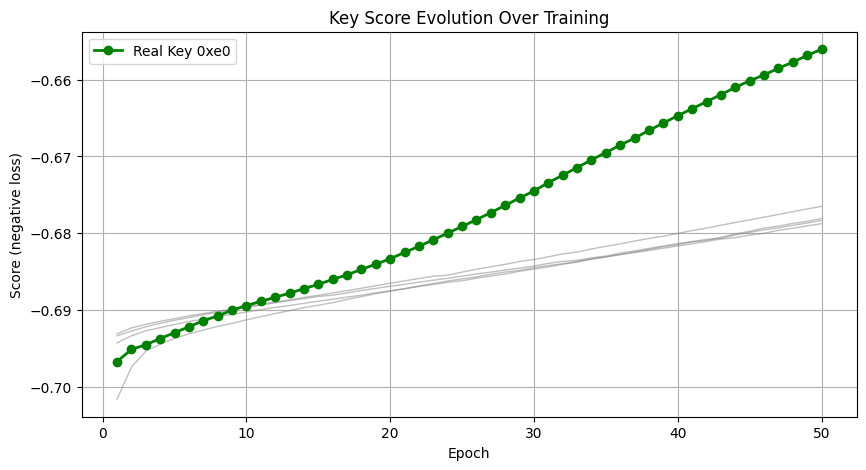

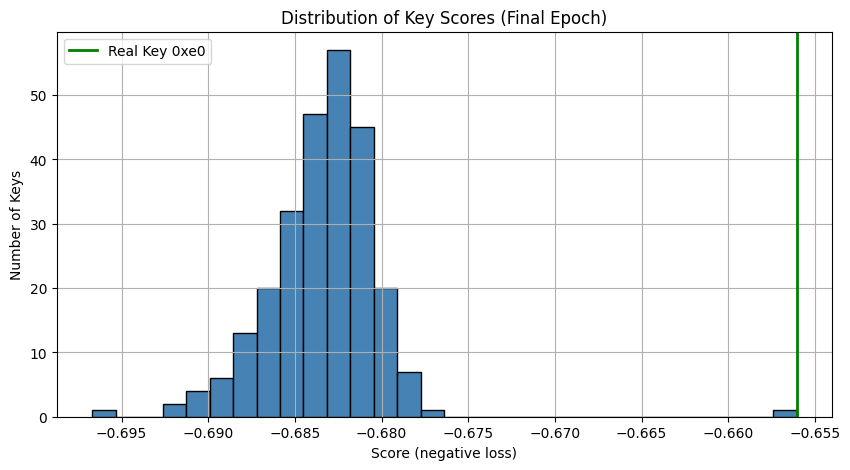

In [7]:
# Get the final scores for all 256 key guesses
final_scores = key_scores[-1]
epochs_range = np.arange(1, MLP_NUM_EPOCHS + 1)

# Calculate the rank of the real key at each epoch
real_key_ranks = []
for epoch in range(MLP_NUM_EPOCHS):
    sorted_keys = np.argsort(key_scores[epoch])[::-1]  # Sort by score (highest first)
    rank = np.where(sorted_keys == real_key)[0][0] + 1  # +1 for 1-based ranking
    real_key_ranks.append(rank)

# ---- Chart 1: Key Score Evolution ----
plt.figure(figsize=(10, 5))

# Plot a few wrong keys in gray
sorted_final = np.argsort(final_scores)[::-1]
for k in sorted_final[:5]:
    if k != real_key:
        plt.plot(epochs_range, key_scores[:, k], color='gray', alpha=0.5, linewidth=1)

# Plot the real key in green
plt.plot(epochs_range, key_scores[:, real_key], color='green', linewidth=2, 
         marker='o', label=f'Real Key {hex(real_key)}')

plt.xlabel('Epoch')
plt.ylabel('Score (negative loss)')
plt.title('Key Score Evolution Over Training')
plt.legend()
plt.grid(True)
plt.show()

# ---- Chart 2: Score Distribution at Final Epoch ----
plt.figure(figsize=(10, 5))

plt.hist(final_scores, bins=30, color='steelblue', edgecolor='black')
plt.axvline(x=final_scores[real_key], color='green', linewidth=2, label=f'Real Key {hex(real_key)}')

plt.xlabel('Score (negative loss)')
plt.ylabel('Number of Keys')
plt.title('Distribution of Key Scores (Final Epoch)')
plt.legend()
plt.grid(True)
plt.show()



In [8]:
# Print summary
print("=" * 50)
print("ATTACK SUMMARY")
print("=" * 50)
print(f"Target Key Byte:  {hex(real_key)}")
print(f"Final Rank:       {real_key_ranks[-1]}")
print(f"Final Score:      {final_scores[real_key]:.4f}")

if real_key_ranks[-1] == 1:
    print("Result:           KEY RECOVERED!")
else:
    print(f"Result:           Key not recovered (rank {real_key_ranks[-1]})")
print("=" * 50)

ATTACK SUMMARY
Target Key Byte:  0xe0
Final Rank:       1
Final Score:      -0.6560
Result:           KEY RECOVERED!


## 7. Save Model

Save the trained model to the checkpoints directory for later use in demos.


In [ ]:
# Save the trained model with versioned checkpoint
exp = ExperimentManager(checkpoint_dir=CHECKPOINT_DIR)

# Prepare config dict for saving
config_dict = {
    'MLP_LEARNING_RATE': MLP_LEARNING_RATE,
    'MLP_SHARED_DIM': MLP_SHARED_DIM,
    'MLP_BRANCH_LAYER_1': MLP_BRANCH_LAYER_1,
    'MLP_BRANCH_LAYER_2': MLP_BRANCH_LAYER_2,
    'MLP_OUTPUT_CLASSES': MLP_OUTPUT_CLASSES,
    'NUM_TRACES': NUM_TRACES,
    'MLP_NUM_EPOCHS': MLP_NUM_EPOCHS,
    'MLP_BATCH_SIZE': MLP_BATCH_SIZE,
    'TARGET_BYTE_IDX': TARGET_BYTE_IDX,
    'input_dim': input_dim,
}

# Prepare results with training outcomes
results = {
    'real_key': int(real_key),
    'final_rank': real_key_ranks[-1],
    'final_score': float(final_scores[real_key]),
    'key_recovered': real_key_ranks[-1] == 1,
}

# Save model using ExperimentManager (auto-incrementing run ID)
run_id = exp.save_run(
    model=model,
    model_type='mlp',
    config=config_dict,
    results=results
)

print(f"\nCheckpoint saved with:")
print(f"  - Run ID: {run_id}")
print(f"  - Config: {len(config_dict)} parameters")
print(f"  - Results: Final rank={results['final_rank']}, Key recovered={results['key_recovered']}")


Checkpoint saved: checkpoints/mlp_run_005.pt
Run logged: mlp_run_005 @ 2025-12-14T21:00:58

Checkpoint saved with:
  - Run ID: mlp_run_005
  - Config: 10 parameters
  - Results: Final rank=1, Key recovered=True
